In [15]:
import numpy as np
import os
import glob
import re
from skimage import io, transform
import matplotlib.pyplot as plt
import cv2
from itertools import product
import pandas as pd
from tqdm.notebook import tqdm

# 手动偏移量 - 已知正确的方向
manual_shift = [-24, 17]  # [y, x]

# 用于查找对应文件的函数
def find_matching_files(dic_file):
    """根据DIC文件名查找对应的DAPI和CY3文件"""
    # 提取基本文件名部分
    base_name_match = re.search(r'(WT\+pWL74 CLB2_Q570 MS2v6_Q670_\d+)_DIC_s(\d+)', dic_file)
    
    if not base_name_match:
        return None, None
    
    base_name = base_name_match.group(1)
    segment = base_name_match.group(2)
    
    # 构造DAPI和CY3文件名模式
    dapi_pattern = f"/Users/zhaoyonghao/Documents/MATLAB/DAPI_processed/MAX_{base_name}_w3DAPI-12-_s{segment}.tif"
    cy3_pattern = f"/Users/zhaoyonghao/Documents/MATLAB/CY3_processed/MAX_{base_name}_w2CY3-100-_s{segment}.tif"
    
    # 查找匹配的文件
    dapi_files = glob.glob(dapi_pattern)
    cy3_files = glob.glob(cy3_pattern)
    
    dapi_file = dapi_files[0] if dapi_files else None
    cy3_file = cy3_files[0] if cy3_files else None
    
    return dapi_file, cy3_file

# 使用Lucas-Kanade方法估计平移
def estimate_lk_translation(dic_image, target_image, lk_params, feature_params):
    """使用Lucas-Kanade方法估计两个图像之间的平移"""
    # 确保图像数据类型和范围正确
    dic_image_8bit = (dic_image * 255).astype(np.uint8)
    target_image_8bit = (target_image * 255).astype(np.uint8)
    
    # 预处理：增强图像对比度
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    dic_enhanced = clahe.apply(dic_image_8bit)
    target_enhanced = clahe.apply(target_image_8bit)
    
    # 在DIC图像上检测特征点
    prev_pts = cv2.goodFeaturesToTrack(dic_enhanced, **feature_params)
    
    if prev_pts is None or len(prev_pts) < 10:
        # 如果检测到的特征点太少，调整参数重试
        adjusted_params = feature_params.copy()
        adjusted_params['qualityLevel'] = feature_params['qualityLevel'] / 2
        prev_pts = cv2.goodFeaturesToTrack(dic_enhanced, **adjusted_params)
        
        if prev_pts is None or len(prev_pts) < 5:
            # 如果仍然不足，返回None表示失败
            return None, 0
    
    # 使用光流法计算特征点在目标图像中的位置
    next_pts, status, error = cv2.calcOpticalFlowPyrLK(
        dic_enhanced, target_enhanced, prev_pts, None, **lk_params
    )
    
    # 仅保留成功跟踪的点
    good_old = prev_pts[status == 1]
    good_new = next_pts[status == 1]
    
    if len(good_new) < 5:
        return None, 0
    
    # 计算每个特征点的位移
    point_shifts = good_new - good_old
    
    # 使用中值作为平移估计，并反向得到DIC对齐到目标的变换
    median_shift = np.median(point_shifts, axis=0)
    tx, ty = -median_shift[0], -median_shift[1]  # 注意反向
    print(f"估计的平移量: [x={tx}, y={ty}]")
    
    return (tx, ty), len(good_new)

# 计算与手动偏移的均方误差
def calculate_mse(estimated_shift, manual_shift):
    """计算估计的偏移与手动偏移之间的均方误差"""
    # 手动偏移是[y, x]格式，而估计的偏移是[x, y]格式
    manual_x = manual_shift[1]   # 不需要再取负
    manual_y = manual_shift[0]   # 不需要再取负
    
    estimated_x, estimated_y = estimated_shift
    
    # 计算MSE
    mse = ((estimated_x - manual_x) ** 2 + (estimated_y - manual_y) ** 2) / 2
    return mse

# 使用估计的偏移量对齐图像并保存
def align_and_save(dic_image, target_image, shift, output_path):
    """使用估计的偏移量对齐图像并保存结果"""
    tx, ty = shift
    
    # 创建变换矩阵
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    warp_matrix[0, 2] = tx
    warp_matrix[1, 2] = ty
    
    # 应用变换到DIC图像
    height, width = target_image.shape
    dic_image_8bit = (dic_image * 255).astype(np.uint8)
    aligned_dic = cv2.warpAffine(dic_image_8bit, warp_matrix, (width, height), flags=cv2.INTER_LINEAR)
    
    # 保存结果
    io.imsave(output_path, aligned_dic)
    
    return aligned_dic

# 网格搜索参数
def grid_search_lk_parameters(dic_file, target_file, parameter_grid, manual_shift):
    """对Lucas-Kanade参数进行网格搜索"""
    # 读取图像
    dic_image = io.imread(dic_file, as_gray=True)
    target_image = io.imread(target_file, as_gray=True)
    
    results = []
    
    # 遍历所有参数组合
    for params in parameter_grid:
        # 解包参数
        win_size, max_level, quality_level, min_distance = params
        
        # 设置Lucas-Kanade参数
        lk_params = dict(
            winSize=(win_size, win_size),
            maxLevel=max_level,
            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
        )
        
        # 设置特征点检测参数
        feature_params = dict(
            maxCorners=200,
            qualityLevel=quality_level,
            minDistance=min_distance,
            blockSize=7
        )
        
        # 估计平移
        estimated_shift, num_points = estimate_lk_translation(dic_image, target_image, lk_params, feature_params)
        
        if estimated_shift is not None:
            # 计算MSE
            mse = calculate_mse(estimated_shift, manual_shift)
            print('estimated_shift_x', estimated_shift[0],
                'estimated_shift_y', estimated_shift[1],
                'mse:',mse)
            # 记录结果
            results.append({
                'win_size': win_size,
                'max_level': max_level,
                'quality_level': quality_level,
                'min_distance': min_distance,
                'estimated_shift_x': estimated_shift[0],
                'estimated_shift_y': estimated_shift[1],
                'num_points': num_points,
                'mse': mse
            })
    
    # 转换为DataFrame
    return pd.DataFrame(results)

# 批量处理所有文件
def process_all_files():
    """批量处理所有DIC文件及其对应的DAPI和CY3文件"""
    # 查找所有DIC文件
    dic_pattern = "/Users/zhaoyonghao/Documents/MATLAB/DIC_mask/*.tif"
    dic_files = glob.glob(dic_pattern)
    
    # 参数网格
    win_sizes = [9,10,11, 12]
    max_levels = [3]
    quality_levels = [0.01]
    min_distances = [10]
    
    parameter_grid = list(product(win_sizes, max_levels, quality_levels, min_distances))
    
    all_results = []
    
    # 遍历所有DIC文件
    for dic_file in tqdm(dic_files, desc="处理文件"):
        # 查找对应的DAPI和CY3文件
        dapi_file, cy3_file = find_matching_files(dic_file)
        
        if dapi_file and cy3_file:
            # 对DAPI文件进行网格搜索
            dapi_results = grid_search_lk_parameters(dic_file, dapi_file, parameter_grid, manual_shift)
            dapi_results['target_type'] = 'DAPI'
            dapi_results['dic_file'] = os.path.basename(dic_file)
            dapi_results['target_file'] = os.path.basename(dapi_file)
            
            # 对CY3文件进行网格搜索
            cy3_results = grid_search_lk_parameters(dic_file, cy3_file, parameter_grid, manual_shift)
            cy3_results['target_type'] = 'CY3'
            cy3_results['dic_file'] = os.path.basename(dic_file)
            cy3_results['target_file'] = os.path.basename(cy3_file)
            
            # 合并结果
            all_results.append(dapi_results)
            all_results.append(cy3_results)
    
    # 合并所有结果
    if all_results:
        combined_results = pd.concat(all_results)
        return combined_results
    else:
        return pd.DataFrame()

# 可视化最佳参数对齐结果
def visualize_best_alignment(dic_file, target_file, best_params):
    """可视化使用最佳参数的对齐结果"""
    # 读取图像
    dic_image = io.imread(dic_file, as_gray=True)
    target_image = io.imread(target_file, as_gray=True)
    
    # 设置Lucas-Kanade参数
    lk_params = dict(
        winSize=(best_params['win_size'], best_params['win_size']),
        maxLevel=best_params['max_level'],
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )
    
    # 设置特征点检测参数
    feature_params = dict(
        maxCorners=200,
        qualityLevel=best_params['quality_level'],
        minDistance=best_params['min_distance'],
        blockSize=7
    )
    
    # 估计平移
    estimated_shift, _ = estimate_lk_translation(dic_image, target_image, lk_params, feature_params)
    
    if estimated_shift is None:
        print("无法使用最佳参数估计平移")
        return
    
    # 使用估计的偏移量对齐图像
    tx, ty = estimated_shift
    
    # 创建变换矩阵
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    warp_matrix[0, 2] = tx
    warp_matrix[1, 2] = ty
    
    # 应用变换到DIC图像
    height, width = target_image.shape
    dic_image_8bit = (dic_image * 255).astype(np.uint8)
    aligned_dic = cv2.warpAffine(dic_image_8bit, warp_matrix, (width, height), flags=cv2.INTER_LINEAR)
    aligned_dic_float = aligned_dic.astype(float) / 255.0
    
    # 使用手动偏移量对齐图像
    manual_matrix = np.eye(2, 3, dtype=np.float32)
    manual_matrix[0, 2] = manual_shift[1]  # x轴偏移
    manual_matrix[1, 2] = manual_shift[0]  # y轴偏移
    
    manual_aligned_dic = cv2.warpAffine(dic_image_8bit, manual_matrix, (width, height), flags=cv2.INTER_LINEAR)
    manual_aligned_dic_float = manual_aligned_dic.astype(float) / 255.0
    
    # 可视化
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 原始图像
    axes[0, 0].imshow(dic_image, cmap='gray')
    axes[0, 0].set_title('DIC Image (Original)')
    
    axes[0, 1].imshow(target_image, cmap='gray')
    axes[0, 1].set_title('Target Image')
    
    # 对齐结果
    axes[1, 0].imshow(target_image, cmap='gray')
    axes[1, 0].imshow(aligned_dic_float, cmap='jet', alpha=0.5)
    axes[1, 0].set_title(f'Target with Aligned DIC (LK: x={tx:.1f}, y={ty:.1f})')
    
    axes[1, 1].imshow(target_image, cmap='gray')
    axes[1, 1].imshow(manual_aligned_dic_float, cmap='jet', alpha=0.5)
    axes[1, 1].set_title(f'Target with Aligned DIC (Manual: x={manual_shift[1]}, y={manual_shift[0]})')
    
    plt.tight_layout()
    plt.show()
    
    # 计算MSE
    mse = calculate_mse(estimated_shift, manual_shift)
    print(f"最佳参数MSE: {mse:.2f}")
    print(f"估计的偏移: [x={tx:.2f}, y={ty:.2f}]")
    print(f"手动偏移: [x={manual_shift[1]}, y={manual_shift[0]}]")
    
    return aligned_dic

# 使用最佳参数批量处理所有文件
def process_with_best_params(best_dapi_params, best_cy3_params):
    """使用找到的最佳参数批量处理所有文件"""
    # 查找所有DIC文件
    dic_pattern = "/Users/zhaoyonghao/Documents/MATLAB/DIC_mask/*.tif"
    dic_files = glob.glob(dic_pattern)
    
    # 设置DAPI的Lucas-Kanade参数
    dapi_lk_params = dict(
        winSize=(best_dapi_params['win_size'], best_dapi_params['win_size']),
        maxLevel=best_dapi_params['max_level'],
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )
    
    # 设置DAPI的特征点检测参数
    dapi_feature_params = dict(
        maxCorners=200,
        qualityLevel=best_dapi_params['quality_level'],
        minDistance=best_dapi_params['min_distance'],
        blockSize=7
    )
    
    # 设置CY3的Lucas-Kanade参数
    cy3_lk_params = dict(
        winSize=(best_cy3_params['win_size'], best_cy3_params['win_size']),
        maxLevel=best_cy3_params['max_level'],
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03)
    )
    
    # 设置CY3的特征点检测参数
    cy3_feature_params = dict(
        maxCorners=200,
        qualityLevel=best_cy3_params['quality_level'],
        minDistance=best_cy3_params['min_distance'],
        blockSize=7
    )
    
    results = []
    
    # 创建输出目录
    os.makedirs('/Users/zhaoyonghao/Documents/MATLAB/aligned_dic_best', exist_ok=True)
    
    # 遍历所有DIC文件
    for dic_file in tqdm(dic_files, desc="应用最佳参数"):
        # 查找对应的DAPI和CY3文件
        dapi_file, cy3_file = find_matching_files(dic_file)
        
        if dapi_file and cy3_file:
            # 读取图像
            dic_image = io.imread(dic_file, as_gray=True)
            dapi_image = io.imread(dapi_file, as_gray=True)
            cy3_image = io.imread(cy3_file, as_gray=True)
            
            # 处理DAPI
            dapi_shift, dapi_points = estimate_lk_translation(dic_image, dapi_image, dapi_lk_params, dapi_feature_params)
            
            # 处理CY3
            cy3_shift, cy3_points = estimate_lk_translation(dic_image, cy3_image, cy3_lk_params, cy3_feature_params)
            
            # 记录结果
            file_result = {
                'dic_file': os.path.basename(dic_file),
                'dapi_file': os.path.basename(dapi_file),
                'cy3_file': os.path.basename(cy3_file)
            }
            
            # 保存DAPI对齐结果
            if dapi_shift is not None:
                dapi_mse = calculate_mse(dapi_shift, manual_shift)
                file_result.update({
                    'dapi_shift_x': dapi_shift[0],
                    'dapi_shift_y': dapi_shift[1],
                    'dapi_points': dapi_points,
                    'dapi_mse': dapi_mse
                })
                
                # 保存对齐结果
                dapi_output = f'/Users/zhaoyonghao/Documents/MATLAB/aligned_dic_best/DAPI_{os.path.basename(dic_file)}'
                align_and_save(dic_image, dapi_image, dapi_shift, dapi_output)
            else:
                file_result.update({
                    'dapi_shift_x': None,
                    'dapi_shift_y': None,
                    'dapi_points': 0,
                    'dapi_mse': None
                })
            
            # 保存CY3对齐结果
            if cy3_shift is not None:
                cy3_mse = calculate_mse(cy3_shift, manual_shift)
                file_result.update({
                    'cy3_shift_x': cy3_shift[0],
                    'cy3_shift_y': cy3_shift[1],
                    'cy3_points': cy3_points,
                    'cy3_mse': cy3_mse
                })
                
                # 保存对齐结果
                cy3_output = f'/Users/zhaoyonghao/Documents/MATLAB/aligned_dic_best/CY3_{os.path.basename(dic_file)}'
                align_and_save(dic_image, cy3_image, cy3_shift, cy3_output)
            else:
                file_result.update({
                    'cy3_shift_x': None,
                    'cy3_shift_y': None,
                    'cy3_points': 0,
                    'cy3_mse': None
                })
            
            # 使用手动偏移量也保存一份
            manual_matrix = np.eye(2, 3, dtype=np.float32)
            manual_matrix[0, 2] = manual_shift[1]  # x轴偏移
            manual_matrix[1, 2] = manual_shift[0]  # y轴偏移
            
            dic_image_8bit = (dic_image * 255).astype(np.uint8)
            
            # 对DAPI应用手动偏移
            height, width = dapi_image.shape
            manual_dapi = cv2.warpAffine(dic_image_8bit, manual_matrix, (width, height), flags=cv2.INTER_LINEAR)
            dapi_manual_output = f'/Users/zhaoyonghao/Documents/MATLAB/aligned_dic_best/MANUAL_DAPI_{os.path.basename(dic_file)}'
            io.imsave(dapi_manual_output, manual_dapi)
            
            # 对CY3应用手动偏移
            height, width = cy3_image.shape
            manual_cy3 = cv2.warpAffine(dic_image_8bit, manual_matrix, (width, height), flags=cv2.INTER_LINEAR)
            cy3_manual_output = f'/Users/zhaoyonghao/Documents/MATLAB/aligned_dic_best/MANUAL_CY3_{os.path.basename(dic_file)}'
            io.imsave(cy3_manual_output, manual_cy3)
            
            results.append(file_result)
    
    # 保存批处理结果
    pd.DataFrame(results).to_csv('/Users/zhaoyonghao/Documents/MATLAB/best_params_results.csv', index=False)
    print("批处理完成，结果已保存")

# 运行完整的处理流程
def run_full_pipeline():
    """运行完整的处理流程"""
    # 进行网格搜索找到最佳参数
    print("开始网格搜索最佳参数...")
    all_results = process_all_files()
    
    if all_results.empty:
        print("未找到有效的文件或处理结果")
        return
    
    # 保存结果
    all_results.to_csv('/Users/zhaoyonghao/Documents/MATLAB/lk_grid_search_results.csv', index=False)
    
    # 找到每种类型的最佳参数
    best_dapi_params = all_results[all_results['target_type'] == 'DAPI'].sort_values('mse').iloc[0]
    best_cy3_params = all_results[all_results['target_type'] == 'CY3'].sort_values('mse').iloc[0]
    
    print("\n最佳DAPI参数:")
    print(best_dapi_params[['win_size', 'max_level', 'quality_level', 'min_distance', 'mse']])
    
    print("\n最佳CY3参数:")
    print(best_cy3_params[['win_size', 'max_level', 'quality_level', 'min_distance', 'mse']])
    
    # 可视化最佳结果
    best_dapi_file = os.path.join('/Users/zhaoyonghao/Documents/MATLAB/DAPI_processed/', best_dapi_params['target_file'])
    best_dic_file = os.path.join('/Users/zhaoyonghao/Documents/MATLAB/DIC_mask/', best_dapi_params['dic_file'])
    
    print("\n可视化DAPI最佳对齐结果:")
    visualize_best_alignment(best_dic_file, best_dapi_file, best_dapi_params)
    
    best_cy3_file = os.path.join('/Users/zhaoyonghao/Documents/MATLAB/CY3_processed/', best_cy3_params['target_file'])
    
    print("\n可视化CY3最佳对齐结果:")
    visualize_best_alignment(best_dic_file, best_cy3_file, best_cy3_params)
    
    # 使用最佳参数批量处理所有文件
    process_with_best_params(best_dapi_params, best_cy3_params)

# 主执行入口
if __name__ == "__main__":
    run_full_pipeline()

开始网格搜索最佳参数...


处理文件:   0%|          | 0/44 [00:00<?, ?it/s]

估计的平移量: [x=21.486907958984375, y=-13.755477905273438]
estimated_shift_x 21.486908 estimated_shift_y -13.755478 mse: 62.54128799086902
估计的平移量: [x=21.213973999023438, y=-12.032562255859375]
estimated_shift_x 21.213974 estimated_shift_y -12.032562 mse: 80.48857151216362
估计的平移量: [x=21.448577880859375, y=-12.49334716796875]
estimated_shift_x 21.448578 estimated_shift_y -12.493347 mse: 76.09645227948204
估计的平移量: [x=18.988311767578125, y=-12.30853271484375]
estimated_shift_x 18.988312 estimated_shift_y -12.308533 mse: 70.32189548248425
估计的平移量: [x=18.6070556640625, y=-19.022186279296875]
estimated_shift_x 18.607056 estimated_shift_y -19.022186 mse: 13.680628672707826
估计的平移量: [x=17.5308837890625, y=-16.774871826171875]
estimated_shift_x 17.530884 estimated_shift_y -16.774872 mse: 26.242157362867147
估计的平移量: [x=17.773529052734375, y=-14.010986328125]
estimated_shift_x 17.77353 estimated_shift_y -14.010986 mse: 50.189370666164905
估计的平移量: [x=17.611251831054688, y=-13.78442668914795]
estimated_shift_

KeyboardInterrupt: 


分析DAPI的参数影响:


/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 31383 (\N{CJK UNIFIED IDEOGRAPH-7A97}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyp

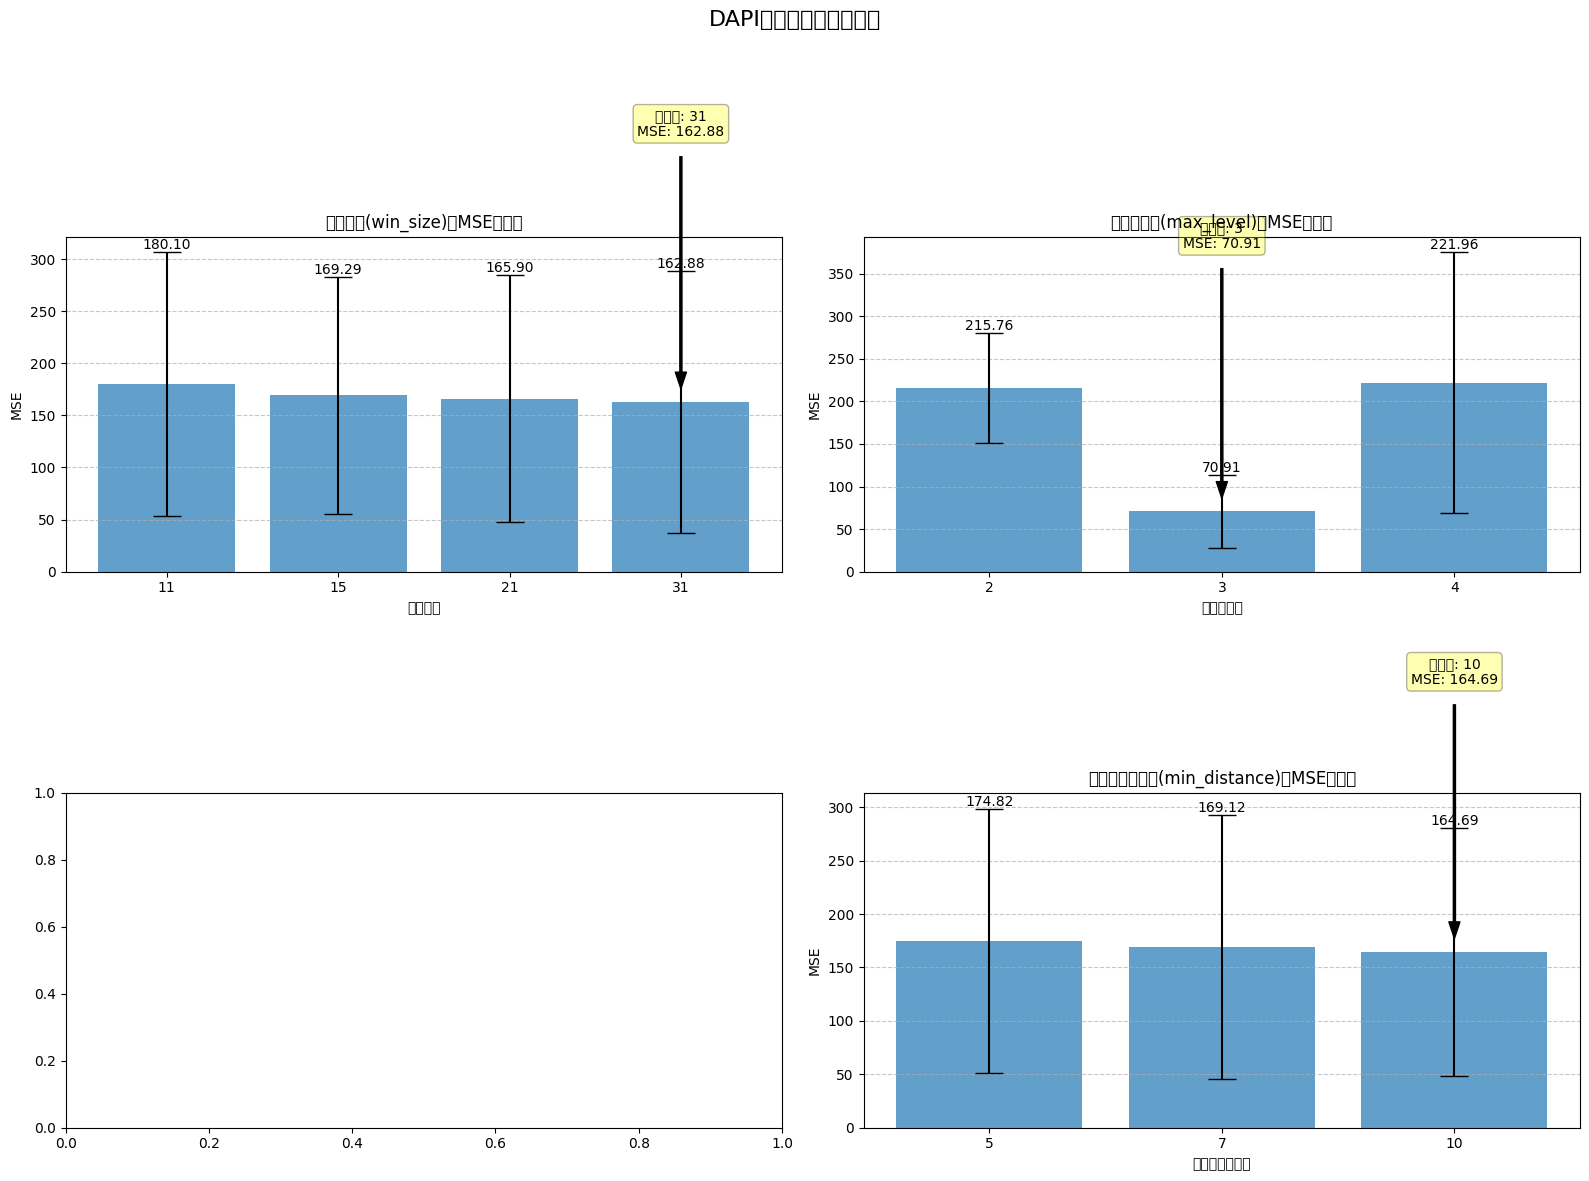

/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21709 (\N{CJK UNIFIED IDEOGRAPH-54CD}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/i

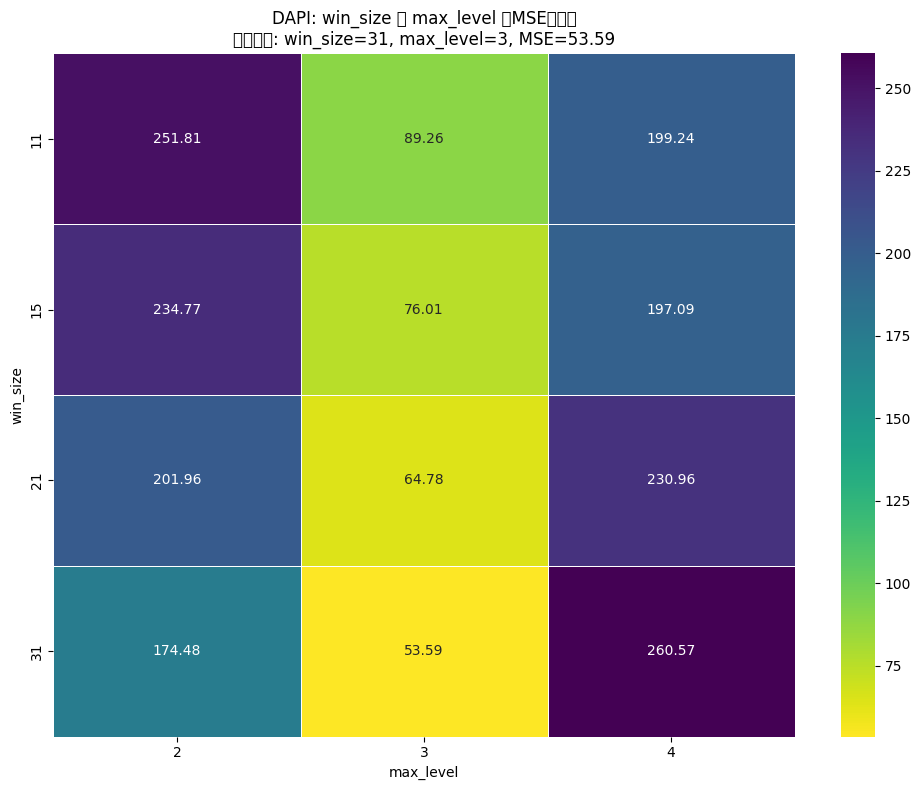

/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21709 (\N{CJK UNIFIED IDEOGRAPH-54CD}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/i

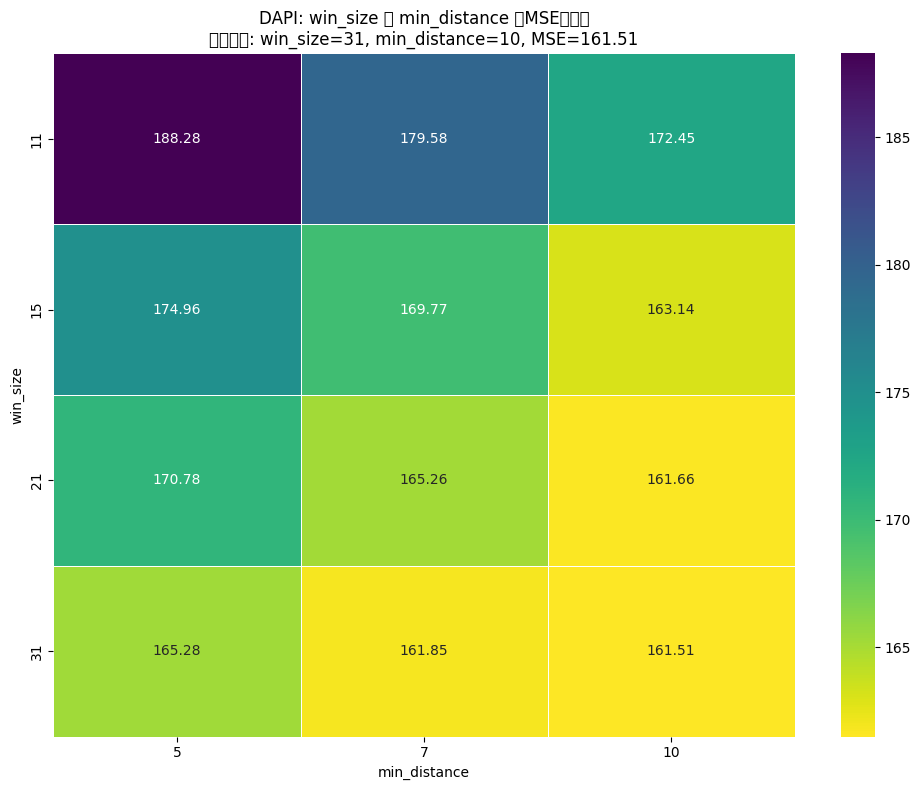

/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21709 (\N{CJK UNIFIED IDEOGRAPH-54CD}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/i

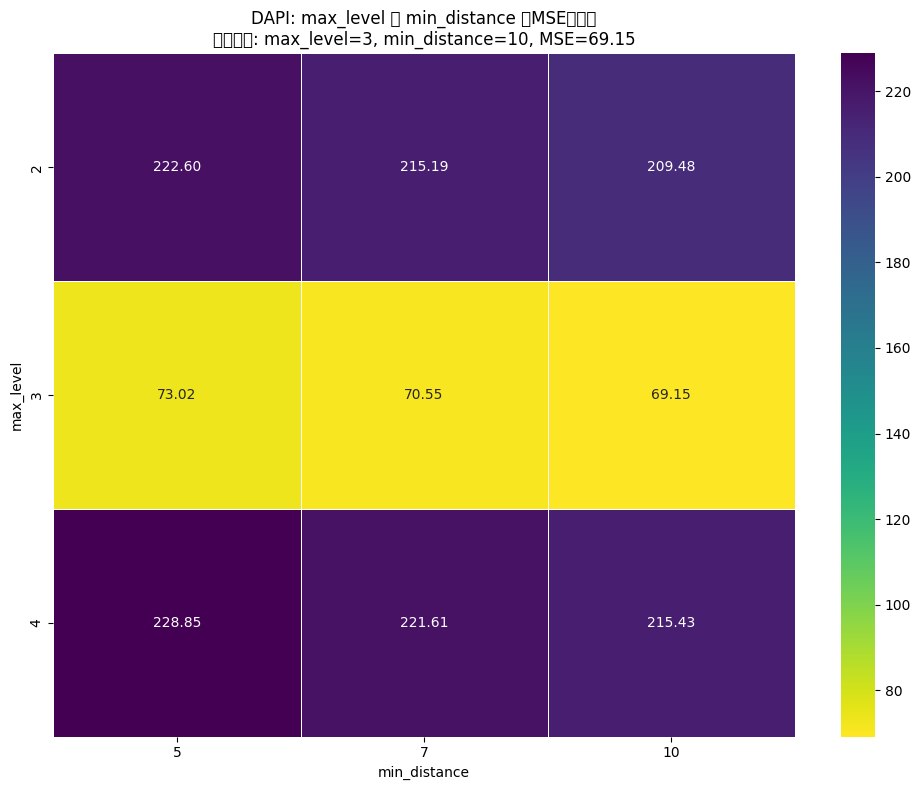

/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 31383 (\N{CJK UNIFIED IDEOGRAPH-7A97}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 22823 (\N{CJK UNIFIED IDEOGRAPH-5927}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 23567 (\N{CJK UNIFIED IDEOGRAPH-5C0F}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyp


分析CY3的参数影响:


/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:38: UserWarning: Glyp

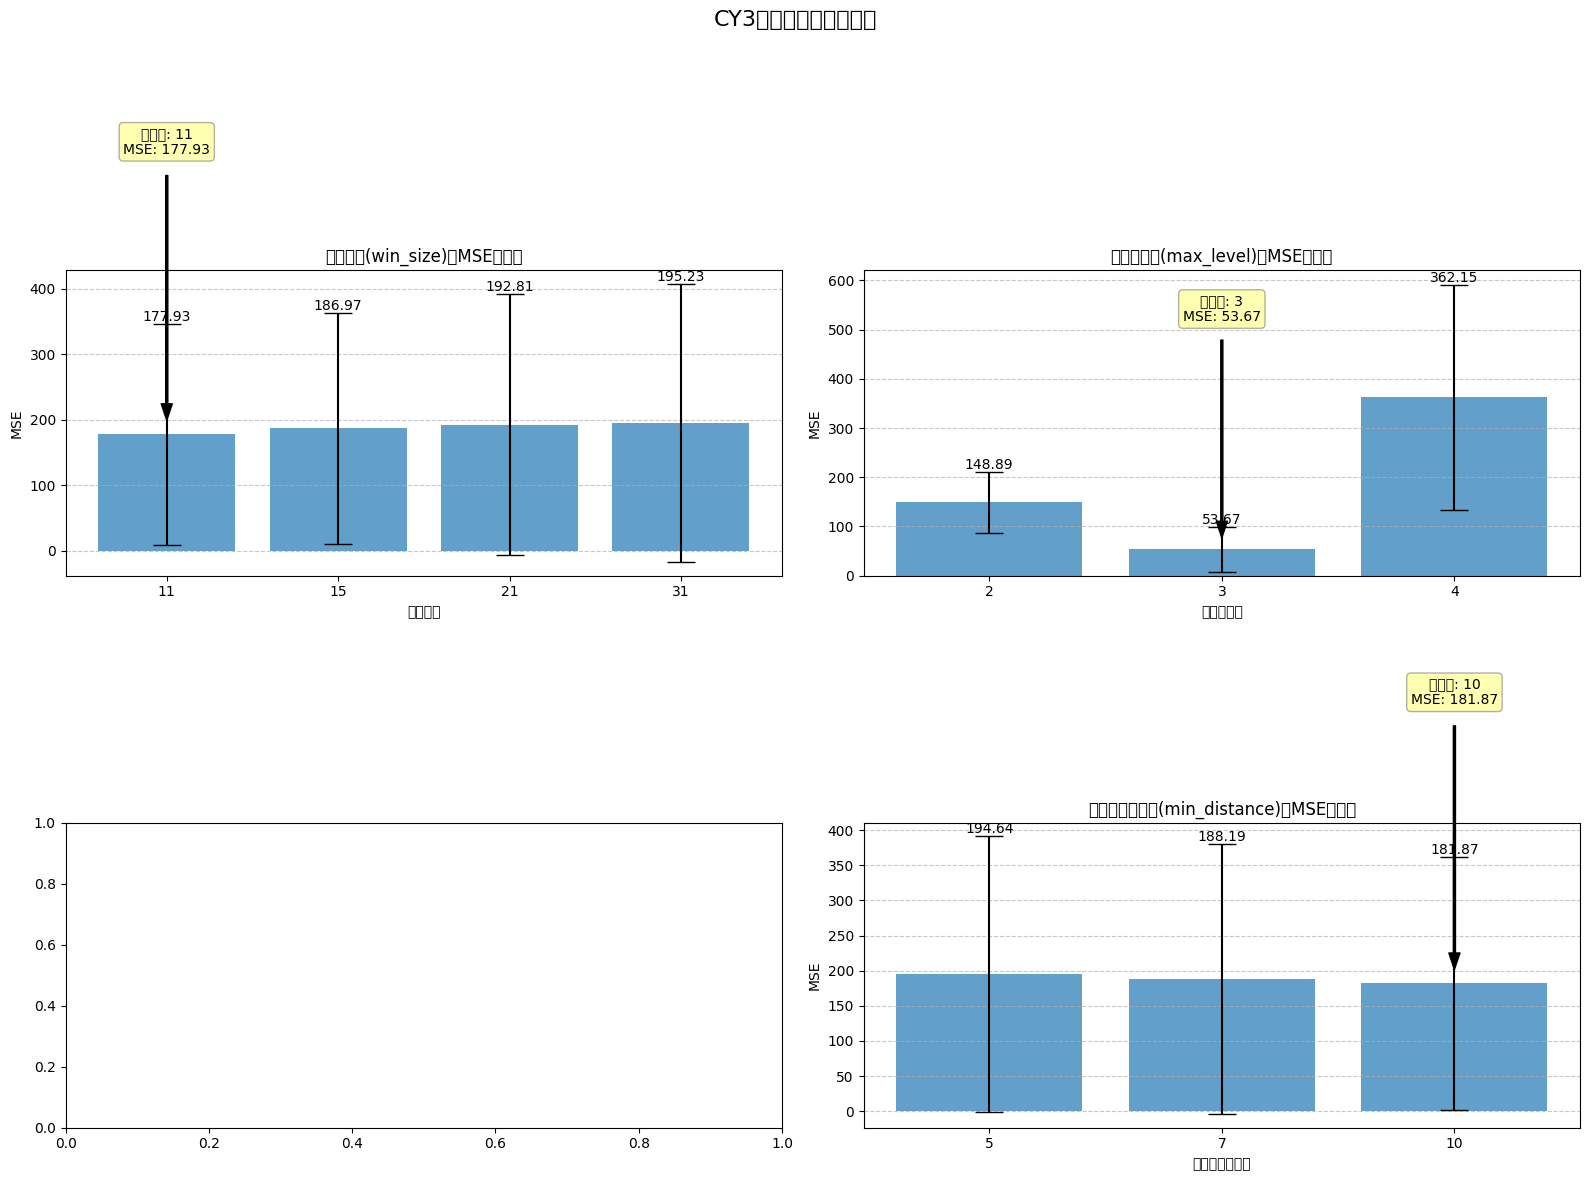

/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21709 (\N{CJK UNIFIED IDEOGRAPH-54CD}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/i

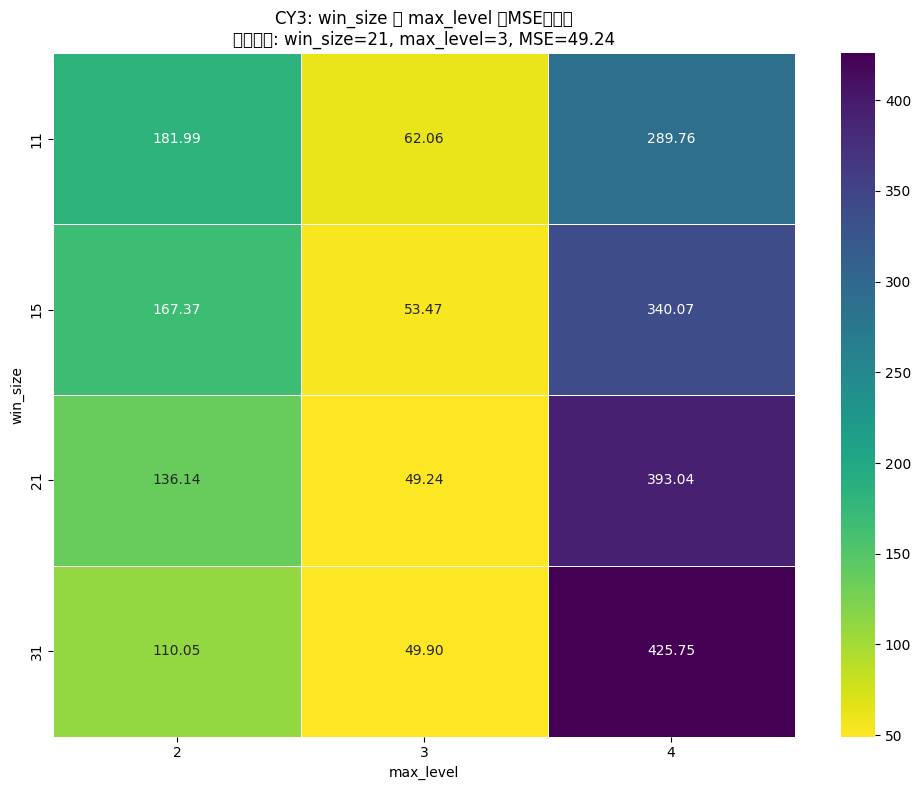

/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21709 (\N{CJK UNIFIED IDEOGRAPH-54CD}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/i

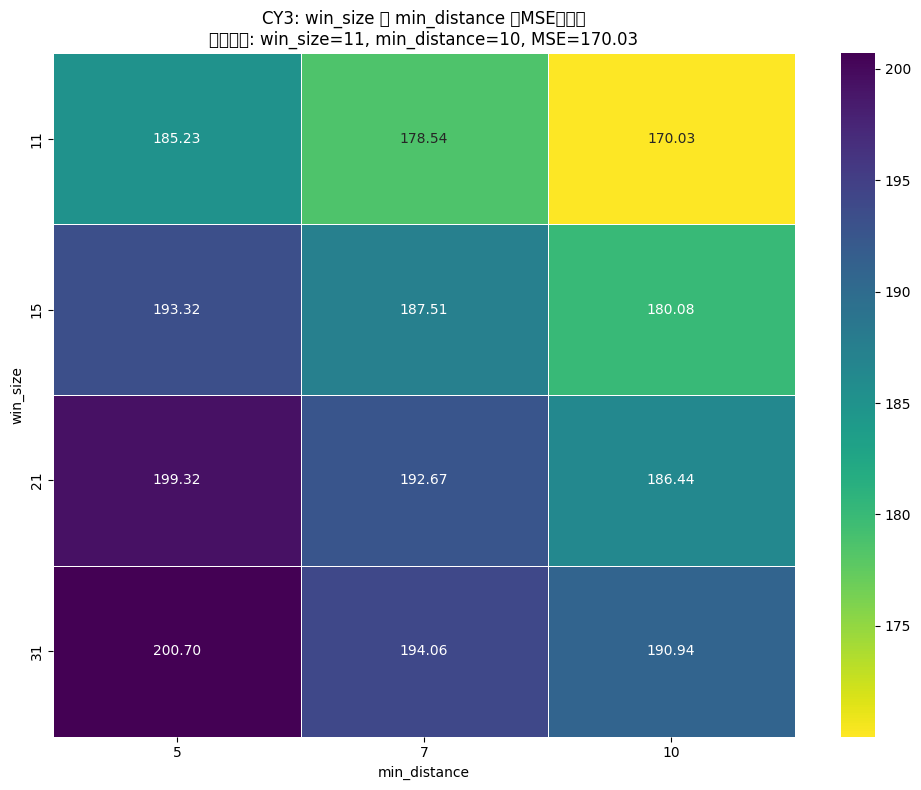

/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 24433 (\N{CJK UNIFIED IDEOGRAPH-5F71}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/ipykernel_31733/3271569689.py:118: UserWarning: Glyph 21709 (\N{CJK UNIFIED IDEOGRAPH-54CD}) missing from current font.
  plt.tight_layout()
/var/folders/mw/bwdxzr752598z0rg9y4m18g80000gn/T/i

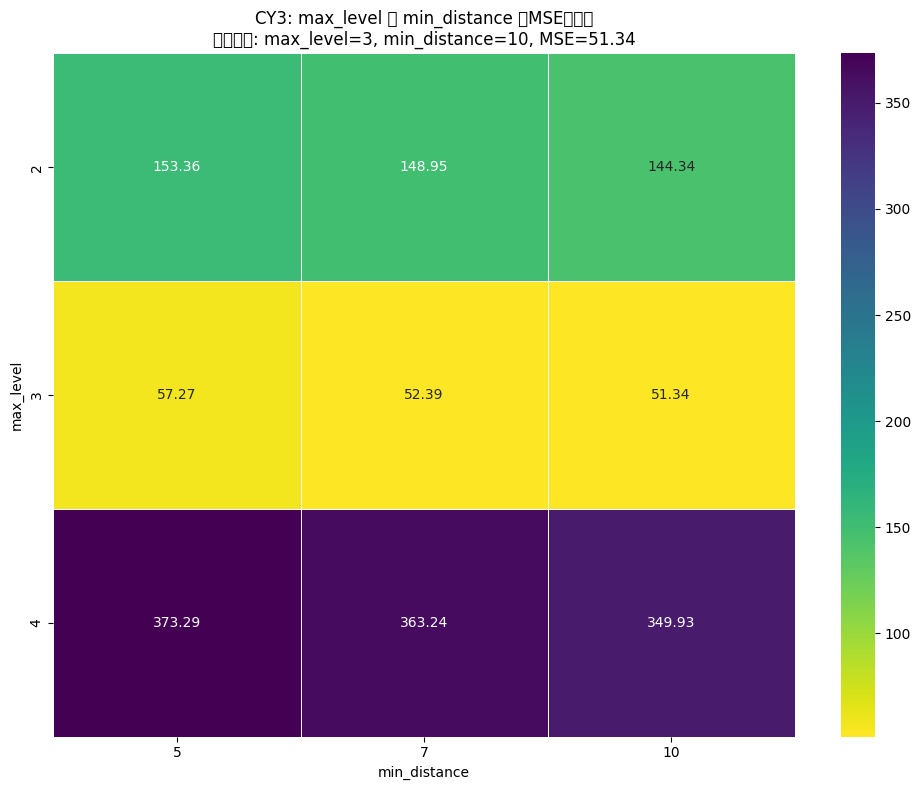


DAPI文件的成功率分析:
                                       dic_file  successful_combinations  \
0    WT+pWL74 CLB2_Q570 MS2v6_Q670_1_DIC_s1.tif                       36   
1    WT+pWL74 CLB2_Q570 MS2v6_Q670_1_DIC_s2.tif                       36   
2    WT+pWL74 CLB2_Q570 MS2v6_Q670_1_DIC_s3.tif                       36   
3    WT+pWL74 CLB2_Q570 MS2v6_Q670_4_DIC_s1.tif                       36   
4    WT+pWL74 CLB2_Q570 MS2v6_Q670_5_DIC_s1.tif                       36   
5   WT+pWL74 CLB2_Q570 MS2v6_Q670_5_DIC_s10.tif                       36   
6    WT+pWL74 CLB2_Q570 MS2v6_Q670_5_DIC_s2.tif                       36   
7    WT+pWL74 CLB2_Q570 MS2v6_Q670_5_DIC_s3.tif                       36   
8    WT+pWL74 CLB2_Q570 MS2v6_Q670_5_DIC_s4.tif                       36   
9    WT+pWL74 CLB2_Q570 MS2v6_Q670_5_DIC_s5.tif                       36   
10   WT+pWL74 CLB2_Q570 MS2v6_Q670_5_DIC_s6.tif                       36   
11   WT+pWL74 CLB2_Q570 MS2v6_Q670_5_DIC_s7.tif                       36 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 读取网格搜索结果
def analyze_grid_search_results(csv_path='/Users/zhaoyonghao/Documents/MATLAB/lk_grid_search_results.csv'):
    """分析网格搜索的结果并可视化参数对MSE的影响"""
    # 读取CSV文件
    df = pd.read_csv(csv_path)
    
    # 分别分析DAPI和CY3的结果
    for target_type in ['DAPI', 'CY3']:
        target_df = df[df['target_type'] == target_type]
        
        if target_df.empty:
            print(f"没有找到{target_type}的结果数据")
            continue
        
        print(f"\n分析{target_type}的参数影响:")
        
        # 创建一个图形，包含4个子图（每个参数一个）
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle(f'{target_type}图像的参数影响分析', fontsize=16)
        
        # 1. 分析窗口大小(win_size)对MSE的影响
        analyze_parameter(target_df, 'win_size', [11, 15, 21, 31], axes[0, 0], 
                           '窗口大小(win_size)对MSE的影响', '窗口大小', 'MSE')
        
        # 2. 分析金字塔层级(max_level)对MSE的影响
        analyze_parameter(target_df, 'max_level', [2, 3, 4], axes[0, 1], 
                           '金字塔层级(max_level)对MSE的影响', '金字塔层级', 'MSE')
        
        # 4. 分析特征点最小距离(min_distance)对MSE的影响
        analyze_parameter(target_df, 'min_distance', [5, 7, 10], axes[1, 1], 
                           '特征点最小距离(min_distance)对MSE的影响', '特征点最小距离', 'MSE')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # 调整布局，为标题留出空间
        plt.savefig(f'/Users/zhaoyonghao/Documents/MATLAB/{target_type}_parameter_analysis.png', dpi=300)
        plt.show()
        
        # 创建参数组合热图
        create_parameter_heatmaps(target_df, target_type)

def analyze_parameter(df, param_name, param_values, ax, title, xlabel, ylabel):
    """分析单个参数对MSE的影响，固定该参数时取其他参数的平均值"""
    mean_mse = []
    std_mse = []
    
    for value in param_values:
        # 选择特定参数值的所有结果
        param_df = df[df[param_name] == value]
        
        # 计算平均MSE和标准差
        mean_mse.append(param_df['mse'].mean())
        std_mse.append(param_df['mse'].std())
    
    # 绘制条形图
    x = np.arange(len(param_values))
    bars = ax.bar(x, mean_mse, yerr=std_mse, alpha=0.7, capsize=10)
    
    # 在条形上标注具体数值
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std_mse[i],
                f'{mean_mse[i]:.2f}', ha='center', va='bottom', fontsize=10)
    
    # 设置图表属性
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(param_values)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 找出最佳参数值（最小MSE）
    best_idx = np.argmin(mean_mse)
    best_value = param_values[best_idx]
    min_mse = mean_mse[best_idx]
    
    # 在最佳值处添加标记
    ax.annotate(f'最佳值: {best_value}\nMSE: {min_mse:.2f}',
                xy=(best_idx, min_mse), xytext=(best_idx, min_mse + max(std_mse) * 2),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                ha='center', va='bottom', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))

def create_parameter_heatmaps(df, target_type):
    """创建参数组合的热图，分析参数交互影响"""
    parameters = ['win_size', 'max_level', 'min_distance']
    
    # 为所有参数对创建热图
    for i, param1 in enumerate(parameters):
        for j, param2 in enumerate(parameters):
            if i < j:  # 避免重复组合
                create_param_heatmap(df, param1, param2, target_type)

def create_param_heatmap(df, param1, param2, target_type):
    """为两个参数创建MSE热图"""
    # 获取参数1的唯一值
    param1_values = sorted(df[param1].unique())
    
    # 获取参数2的唯一值
    param2_values = sorted(df[param2].unique())
    
    # 创建交叉表计算平均MSE
    pivot_table = df.pivot_table(values='mse', index=param1, columns=param2, aggfunc='mean')
    
    # 创建热图
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table, annot=True, cmap='viridis_r', fmt='.2f', linewidths=.5)
    
    # 找出最佳组合（最小MSE）
    min_mse = pivot_table.min().min()
    min_idx = pivot_table.stack().idxmin()
    
    # 设置图表标题和标签
    plt.title(f'{target_type}: {param1} 和 {param2} 对MSE的影响\n最佳组合: {param1}={min_idx[0]}, {param2}={min_idx[1]}, MSE={min_mse:.2f}')
    plt.tight_layout()
    plt.savefig(f'/Users/zhaoyonghao/Documents/MATLAB/{target_type}_{param1}_{param2}_heatmap.png', dpi=300)
    plt.show()

# 分析每个参数组合的成功率
def analyze_success_rate(csv_path='/Users/zhaoyonghao/Documents/MATLAB/lk_grid_search_results.csv'):
    """分析每个参数组合的成功率"""
    # 读取CSV文件
    df = pd.read_csv(csv_path)
    
    # 计算网格搜索中的理论总组合数
    win_sizes = [11, 15, 21, 31]
    max_levels = [2, 3, 4]
    min_distances = [5, 7, 10]
    
    total_combinations = len(win_sizes) * len(max_levels) * len(min_distances)
    
    # 分别分析DAPI和CY3的结果
    for target_type in ['DAPI', 'CY3']:
        target_df = df[df['target_type'] == target_type]
        
        if target_df.empty:
            print(f"没有找到{target_type}的结果数据")
            continue
        
        # 分析每个文件的成功率
        file_success = target_df.groupby('dic_file').size().reset_index(name='successful_combinations')
        file_success['total_combinations'] = total_combinations
        file_success['success_rate'] = file_success['successful_combinations'] / total_combinations * 100
        
        print(f"\n{target_type}文件的成功率分析:")
        print(file_success[['dic_file', 'successful_combinations', 'total_combinations', 'success_rate']])
        
        # 分析每个参数值的成功率
        for param in ['win_size', 'max_level', 'min_distance']:
            param_success = target_df.groupby(param).size().reset_index(name='count')
            total_per_param = len(target_df['dic_file'].unique()) * (total_combinations / len(df[param].unique()))
            param_success['expected_count'] = total_per_param
            param_success['success_rate'] = param_success['count'] / total_per_param * 100
            
            print(f"\n{target_type}的{param}成功率分析:")
            print(param_success)

# 主函数
def main():
    # 分析网格搜索结果
    analyze_grid_search_results()
    
    # 分析成功率
    analyze_success_rate()

if __name__ == "__main__":
    main()